In [1]:
from sklearn.neighbors import DistanceMetric
from math import radians
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse
import torch
from torch.utils.dlpack import to_dlpack, from_dlpack
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_undirected, is_undirected, convert
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
#from torch_geometric.nn import GCNConv
import torch.nn.functional as F
pd.options.mode.chained_assignment = None

def MAPELoss(output, target):
    return torch.mean(torch.abs((target - output) / target))  

### Generate Sample Data

In [2]:
cities_df = pd.DataFrame({
    'house':['h1','h2','h3','h4','h5','h6','t1','t2','t3'],
    'lat':[12.9716,19.076,28.7041,22.5726,13.0827,23.2599,12.9713,19.003,28.7048],
    'lon':[77.5946,72.877,77.1025,80.639,80.2707,77.4126,77.5920,72.8605,77.2000],
    'x1':[20,35,24,33,35,18,19,32,23],
    'x2':[5,5,7,13,16,21,6,6,6],
    'y':[1200,1500,2000,1780,1450,3000,1300,1600,1800],
    'mask':[False,False,False,False,False,False,True,True,True]})
cities_df

,house,lat,lon,x1,x2,y,mask
0,h1,12.9716,77.5946,20,5,1200,False
1,h2,19.0760,72.8770,35,5,1500,False
2,h3,28.7041,77.1025,24,7,2000,False
3,h4,22.5726,80.6390,33,13,1780,False
4,h5,13.0827,80.2707,35,16,1450,False
5,h6,23.2599,77.4126,18,21,3000,False
6,t1,12.9713,77.5920,19,6,1300,True
7,t2,19.0030,72.8605,32,6,1600,True
8,t3,28.7048,77.2000,23,6,1800,True


In [3]:
cities_df['lat'] = np.radians(cities_df['lat'])
cities_df['lon'] = np.radians(cities_df['lon'])

dist = DistanceMetric.get_metric('haversine')

cities_df[['lat','lon']].to_numpy()

df_dist = pd.DataFrame(dist.pairwise(cities_df[['lat','lon']].to_numpy())*6373,  columns=cities_df.house.unique(), index=cities_df.house.unique())
df_dist

,h1,h2,h3,h4,h5,h6,t1,t2,t3
h1,0.000000,845.628325,1750.664163,1115.398072,290.263116,1144.527052,0.283787,840.242766,1750.477562
h2,845.628325,0.000000,1153.629733,895.568328,1033.479952,661.621084,845.489790,8.303050,1157.417037
h3,1750.664163,1153.629733,0.000000,768.561737,1768.206317,606.349722,1750.689713,1161.831857,9.512484
h4,1115.398072,895.568328,768.561737,0.000000,1056.278018,339.263770,1115.509490,900.832222,764.176288
h5,290.263116,1033.479952,1768.206317,1056.278018,0.000000,1171.476936,290.546208,1029.735636,1766.441052
h6,1144.527052,661.621084,606.349722,339.263770,1171.476936,0.000000,1144.555845,668.642547,606.007783
t1,0.283787,845.489790,1750.689713,1115.509490,290.546208,1144.555845,0.000000,840.102374,1750.504667
t2,840.242766,8.303050,1161.831857,900.832222,1029.735636,668.642547,840.102374,0.000000,1165.609158
t3,1750.477562,1157.417037,9.512484,764.176288,1766.441052,606.007783,1750.504667,1165.609158,0.000000


/Users/shao/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/shao/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/shao/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


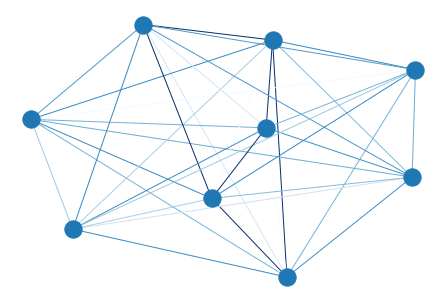

In [4]:
G = nx.from_numpy_matrix(df_dist.values)
nx.draw(G, edge_color = [i[2]['weight'] for i in G.edges(data=True)], edge_cmap = plt.cm.Blues)

In [5]:
D = df_dist.values
D[D <800] = 1
D[D >=800] = 0
D

array([[1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 1., 1., 0., 1., 0., 1., 1.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 1., 0., 0., 1.]])

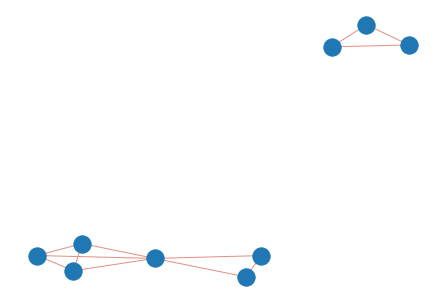

In [6]:
G = nx.from_numpy_matrix(D)
nx.draw(G, edge_color = '#E28F83')

### Training Testing Spilt

In [7]:
def geo_transform(df, m):
    df['lat'] = np.radians(df['lat'])
    df['lon'] = np.radians(df['lon'])
    
    dist = DistanceMetric.get_metric('haversine')
    
    df_dist = pd.DataFrame(dist.pairwise(df[['lat','lon']].to_numpy())*6373,  columns=df.house.unique(), index=df.house.unique())
    
    D = df_dist.values
    D[D < m] = 1
    D[D >= m] = 0
    
    G = nx.from_numpy_matrix(D)
    edge_index = from_networkx(G).edge_index
    
    x = torch.tensor(df[['x1','x2']].values, dtype=torch.float)
    y = torch.tensor(df[['y']].values, dtype=torch.float)
    mask = torch.BoolTensor(df[['mask']].values)
    
    data = Data(x=x, y=y, edge_index=edge_index)
    
    
    return edge_index, x, y, mask, data, G

In [8]:
edge_index, x, y, mask, data, G = geo_transform(cities_df, 800)

In [9]:
edge_index

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         8, 8, 8, 8, 8, 8, 8, 8, 8],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5,
         6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2,
         3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8,
         0, 1, 2, 3, 4, 5, 6, 7, 8]])

In [10]:
x

tensor([[20.,  5.],
        [35.,  5.],
        [24.,  7.],
        [33., 13.],
        [35., 16.],
        [18., 21.],
        [19.,  6.],
        [32.,  6.],
        [23.,  6.]])

In [11]:
y

tensor([[1200.],
        [1500.],
        [2000.],
        [1780.],
        [1450.],
        [3000.],
        [1300.],
        [1600.],
        [1800.]])

In [12]:
mask

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [ True]])

In [13]:
data

Data(edge_index=[2, 81], x=[9, 2], y=[9, 1])

In [14]:
# from torch.utils.data import DataLoader
# loader = DataLoader(data, batch_size=512, shuffle=True)

# pilot

In [15]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j

In [16]:
import torch
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 2)
        self.conv2 = GCNConv(2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(data).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [18]:
num_epochs = 10000

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    out = model(data)
    loss = MAPELoss(out[mask], data.y[mask])
    loss.backward()
  
    optimizer.step()
    # Print the progress
    if (epoch+1) % 1000 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1000/10000], Loss: 0.9552
Epoch [2000/10000], Loss: 0.7839
Epoch [3000/10000], Loss: 0.4451
Epoch [4000/10000], Loss: 0.5721
Epoch [5000/10000], Loss: 0.3032
Epoch [6000/10000], Loss: 0.1921
Epoch [7000/10000], Loss: 0.1725
Epoch [8000/10000], Loss: 0.3837
Epoch [9000/10000], Loss: 0.3462
Epoch [10000/10000], Loss: 0.2354


In [19]:
out

tensor([[1433.2714],
        [1163.8562],
        [1163.8562],
        [1449.3206],
        [1453.1370],
        [1443.9243],
        [1163.8562],
        [1203.1764],
        [1163.8562]], grad_fn=<ScatterAddBackward>)

In [20]:
data.y

tensor([[1200.],
        [1500.],
        [2000.],
        [1780.],
        [1450.],
        [3000.],
        [1300.],
        [1600.],
        [1800.]])

In [21]:
model(data)

tensor([[2135.6611],
        [2107.5752],
        [1904.7592],
        [2111.6057],
        [2155.5278],
        [1866.2329],
        [2135.6567],
        [2106.2820],
        [2138.7207]], grad_fn=<ScatterAddBackward>)

# edge_weight

In [22]:
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.edge_weight = torch.nn.Parameter(torch.ones(data.num_edges))
        self.conv1 = GCNConv(2, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, self.edge_weight.sigmoid()).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, self.edge_weight.sigmoid())
        return x
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    F.MAPELoss(out[mask], data.y[mask]).backward()
    optimizer.step()

In [23]:
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    out = model(data)
    loss = MAPELoss(out[mask], data.y[mask])
    loss.backward()
  
    optimizer.step()
    # Print the progress
    if (epoch+1) % 1000 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [24]:
for epoch in range(2000):
    model.train()
    
    # Print the progress
    if (epoch+1) % 1000 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
        print(model.edge_weight)

Epoch [1000/10], Loss: 0.9727
Parameter containing:
tensor([0.9002, 0.9013, 0.9007, 0.9009, 0.9013, 0.9005, 0.9003, 0.9011, 0.9005,
        0.8998, 0.9006, 0.9005, 0.9001, 0.9007, 0.8997, 0.9050, 0.9028, 0.9022,
        0.8997, 0.9008, 0.9002, 0.9006, 0.9005, 0.8998, 0.9030, 0.9019, 0.9014,
        0.8999, 0.9006, 0.9009, 0.9004, 0.9013, 0.9003, 0.9046, 0.9029, 0.9037,
        0.8998, 0.9015, 0.9008, 0.9007, 0.9010, 0.8998, 0.9057, 0.9065, 0.9053,
        0.8998, 0.9012, 0.9009, 0.9002, 0.9014, 0.9005, 0.9018, 0.9019, 0.9016,
        0.8997, 0.8999, 0.8999, 0.9000, 0.9000, 0.8999, 0.9009, 0.9005, 0.9003,
        0.9000, 0.9006, 0.9004, 0.9007, 0.9002, 0.8999, 0.9019, 0.9018, 0.9008,
        0.8998, 0.9003, 0.9000, 0.9000, 0.9002, 0.9000, 0.9015, 0.9012, 0.9008],
       requires_grad=True)
Epoch [2000/10], Loss: 0.9727
Parameter containing:
tensor([0.9002, 0.9013, 0.9007, 0.9009, 0.9013, 0.9005, 0.9003, 0.9011, 0.9005,
        0.8998, 0.9006, 0.9005, 0.9001, 0.9007, 0.8997, 0.9050, 0.90

In [25]:
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
import networkx as nx

Using backend: pytorch


In [26]:
g = DGLGraph(nx.from_numpy_matrix(D))
# features = x_test
# labels = y_test
# mask = torch.BoolTensor(cities_df[['mask']].values)

/Users/shao/anaconda3/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [27]:
g

Graph(num_nodes=9, num_edges=33,
      ndata_schemes={}
      edata_schemes={})

In [28]:
features = x

In [29]:
labels = y

In [30]:
mask.shape

torch.Size([9, 1])

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)

        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        self.z = edges.src['z']
        self.e = edges.data['e']
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        self.mail = nodes.mailbox['e']
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        self.alpha = alpha
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        self.h = h
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))
        
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [40]:
import time
import numpy as np

# create the model, 2 heads, each head has hidden size 8
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=1,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)

# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    loss = MAPELoss(logits[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))

Epoch 00000 | Loss 1.0063 | Time(s) nan
Epoch 00001 | Loss 0.9908 | Time(s) nan
Epoch 00002 | Loss 0.9750 | Time(s) nan
Epoch 00003 | Loss 0.9575 | Time(s) 0.0072
Epoch 00004 | Loss 0.9374 | Time(s) 0.0076
Epoch 00005 | Loss 0.9164 | Time(s) 0.0089
Epoch 00006 | Loss 0.8925 | Time(s) 0.0088
Epoch 00007 | Loss 0.8656 | Time(s) 0.0086
Epoch 00008 | Loss 0.8351 | Time(s) 0.0088
Epoch 00009 | Loss 0.8007 | Time(s) 0.0085
Epoch 00010 | Loss 0.7622 | Time(s) 0.0084
Epoch 00011 | Loss 0.7193 | Time(s) 0.0082
Epoch 00012 | Loss 0.6715 | Time(s) 0.0081
Epoch 00013 | Loss 0.6181 | Time(s) 0.0080
Epoch 00014 | Loss 0.5296 | Time(s) 0.0078
Epoch 00015 | Loss 0.4598 | Time(s) 0.0077
Epoch 00016 | Loss 0.3910 | Time(s) 0.0077
Epoch 00017 | Loss 0.3170 | Time(s) 0.0076
Epoch 00018 | Loss 0.2377 | Time(s) 0.0075
Epoch 00019 | Loss 0.2248 | Time(s) 0.0075
Epoch 00020 | Loss 0.2144 | Time(s) 0.0074
Epoch 00021 | Loss 0.2041 | Time(s) 0.0074
Epoch 00022 | Loss 0.1940 | Time(s) 0.0073
Epoch 00023 | Loss 0

In [33]:
net

GAT(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=2, out_features=8, bias=False)
        (attn_fc): Linear(in_features=16, out_features=1, bias=False)
      )
      (1): GATLayer(
        (fc): Linear(in_features=2, out_features=8, bias=False)
        (attn_fc): Linear(in_features=16, out_features=1, bias=False)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=16, out_features=1, bias=False)
        (attn_fc): Linear(in_features=2, out_features=1, bias=False)
      )
    )
  )
)

In [34]:
net.layer2

MultiHeadGATLayer(
  (heads): ModuleList(
    (0): GATLayer(
      (fc): Linear(in_features=16, out_features=1, bias=False)
      (attn_fc): Linear(in_features=2, out_features=1, bias=False)
    )
  )
)

In [35]:
net.layer2.heads[0]

GATLayer(
  (fc): Linear(in_features=16, out_features=1, bias=False)
  (attn_fc): Linear(in_features=2, out_features=1, bias=False)
)

In [41]:
net.layer2.heads[0].alpha

tensor([[[5.0000e-01],
         [1.3138e-28],
         [1.3138e-28],
         [1.3138e-28],
         [5.0000e-01],
         [1.3138e-28]]], grad_fn=<SoftmaxBackward>)

In [42]:
net.layer2.heads[0].e

tensor([[3444.8291],
        [3444.8291],
        [3444.8291],
        [2742.6318],
        [3157.5498],
        [2742.6318],
        [3094.0435],
        [3094.0435],
        [3094.0435],
        [3094.0435],
        [3094.0435],
        [3094.0435],
        [3094.0435],
        [3094.0435],
        [3444.8291],
        [3444.8291],
        [3444.8291],
        [2679.1255],
        [3094.0435],
        [3094.0435],
        [3094.0435],
        [2679.1255],
        [3094.0435],
        [3444.8291],
        [3444.8291],
        [3444.8291],
        [2742.6318],
        [3157.5498],
        [2742.6318],
        [3094.0435],
        [3094.0435],
        [3094.0435],
        [3094.0435]], grad_fn=<LeakyReluBackward0>)

In [37]:
net.layer1.heads[0].alpha

tensor([[[4.6987e-13],
         [0.0000e+00],
         [1.0000e+00],
         [1.1135e-38],
         [3.7718e-22],
         [0.0000e+00]]], grad_fn=<SoftmaxBackward>)

In [38]:
x = net.layer2.heads[0].e
x = x/x.sum(0).expand_as(x) 
x[torch.isnan(x)]=0

In [39]:
x

tensor([[0.0330],
        [0.0330],
        [0.0330],
        [0.0272],
        [0.0495],
        [0.0272],
        [0.0300],
        [0.0300],
        [0.0300],
        [0.0300],
        [0.0300],
        [0.0300],
        [0.0300],
        [0.0300],
        [0.0330],
        [0.0330],
        [0.0330],
        [0.0077],
        [0.0300],
        [0.0300],
        [0.0300],
        [0.0077],
        [0.0300],
        [0.0330],
        [0.0330],
        [0.0330],
        [0.0272],
        [0.0495],
        [0.0272],
        [0.0300],
        [0.0300],
        [0.0300],
        [0.0300]], grad_fn=<IndexPutBackward>)